In [19]:

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Intentar importar SHAP y LIME
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

try:
    from lime.lime_tabular import LimeTabularExplainer
    HAS_LIME = True
except Exception:
    HAS_LIME = False

print(f"SHAP disponible: {HAS_SHAP} | LIME disponible: {HAS_LIME}")

SHAP disponible: True | LIME disponible: True


### Funciones Auxiliares

In [20]:
# ---------------------------------------------
# Utilidades de explicabilidad
# ---------------------------------------------

def business_text_from_shap_values(feature_names, instance, shap_values, topn=5):
    """Texto comprensible para negocio a partir de los valores SHAP."""
    abs_imp = np.abs(shap_values)
    idx = np.argsort(abs_imp)[::-1][:topn]
    parts = []
    for i in idx:
        sign = 'aumenta' if shap_values[i] > 0 else 'disminuye'
        parts.append(f"{feature_names[i]} ({sign})")
    return ", ".join(parts)

def extract_top_rules_from_tree(dt_model, feature_names, top_k=3, positive_class=1):
    """Extrae reglas del árbol que predicen la clase positiva con mayor probabilidad."""
    tree_ = dt_model.tree_
    paths = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree_.feature[node]]
            thresh = tree_.threshold[node]
            recurse(tree_.children_left[node], path + [f"{name} <= {thresh:.2f}"])
            recurse(tree_.children_right[node], path + [f"{name} > {thresh:.2f}"])
        else:
            values = tree_.value[node][0]
            pred_class = np.argmax(values)
            prob_pos = values[positive_class] / values.sum()
            paths.append({
                "rule": " and ".join(path),
                "pred_class": pred_class,
                "prob_pos": prob_pos,
                "n_samples": int(tree_.n_node_samples[node])
            })

    recurse(0, [])
    pos_leaves = [p for p in paths if p['pred_class'] == positive_class]
    pos_leaves = sorted(pos_leaves, key=lambda x: (x['prob_pos'], x['n_samples']), reverse=True)
    return pos_leaves[:top_k]


### Carga de datos

In [21]:
# ---------------------------------------------
# Carga y preprocesamiento
# ---------------------------------------------

DATA_PATH = "./datasets_limpios/credit_data_clean.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró {DATA_PATH}. Coloca el CSV en el directorio de trabajo.")

raw = pd.read_csv(DATA_PATH)
if "target" not in raw.columns:
    raise ValueError("El dataset debe contener la columna 'target'.")

X = raw.drop(columns=["target"])
y = raw["target"]

# Codificar variables categóricas
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
encoder = OrdinalEncoder() if len(cat_cols) > 0 else None
if encoder:
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

# Escalamiento
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Datos cargados: {X.shape}, Train: {X_train.shape}, Test: {X_test.shape}")


Datos cargados: (1000, 20), Train: (700, 20), Test: (300, 20)


### Cargar o entrenar modelos

In [22]:
# ---------------------------------------------
# Cargar modelos guardados o entrenarlos si no existen
# ---------------------------------------------

MODELS_DIR = "./modelos/modelos_guardados"
os.makedirs(MODELS_DIR, exist_ok=True)

def try_load_model(filename):
    """Carga un modelo si existe y es válido."""
    path = os.path.join(MODELS_DIR, filename)
    if not os.path.exists(path):
        return None
    try:
        model = joblib.load(path)
        return model
    except Exception as e:
        print(f"⚠️ Error cargando {filename}: {e}")
        return None

models = {}

# --- Árbol ---
tree_model = try_load_model("arbol_decision.pkl")
if tree_model is None:
    tree_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train, y_train)
    joblib.dump(tree_model, os.path.join(MODELS_DIR, "arbol_decision.pkl"))
models["tree"] = tree_model

# --- Logística ---
log_model = try_load_model("log_reg.pkl")
if log_model is None:
    log_model = LogisticRegression(max_iter=1000, solver="liblinear").fit(X_train, y_train)
    joblib.dump(log_model, os.path.join(MODELS_DIR, "log_reg.pkl"))
models["log"] = log_model

# --- Random Forest ---
rf_model = try_load_model("random_forest.pkl")
if rf_model is None:
    rf_model = RandomForestClassifier(
        n_estimators=200, max_depth=6, random_state=42, class_weight="balanced_subsample"
    ).fit(X_train, y_train)
    joblib.dump(rf_model, os.path.join(MODELS_DIR, "random_forest.pkl"))
models["rf"] = rf_model

# --- Red Neuronal ---
nn_model = try_load_model("red_neuronal.pkl")
if nn_model is None:
    nn_model = MLPClassifier(
        hidden_layer_sizes=(32, 16), activation="relu", solver="adam", max_iter=500, random_state=42
    ).fit(X_train_s, y_train)
    joblib.dump(nn_model, os.path.join(MODELS_DIR, "red_neuronal.pkl"))
models["nn"] = nn_model

print("✅ Modelos listos:", [k for k,v in models.items() if v is not None])


✅ Modelos listos: ['tree', 'log', 'rf', 'nn']


### Explicabilidad Global


📊 Coeficientes y Odds Ratios (Logística):


,feature,coef,odds_ratio
0,checking_account_status,0.5311,1.7008
14,housing,0.4975,1.6447
2,credit_history,0.4046,1.4987
5,savings_account,0.2895,1.3357
9,other_debtors,0.2639,1.3020
18,telephone,0.2455,1.2783
13,other_installment_plans,0.2309,1.2597
8,personal_status_sex,0.2262,1.2538
6,employment_since,0.1161,1.1231
10,residence_since,0.0582,1.0599



🌲 Importancia de Variables (Random Forest):


,feature,importance
0,checking_account_status,0.186412
1,duration_months,0.112308
4,credit_amount,0.108787
5,savings_account,0.091912
12,age,0.079963
2,credit_history,0.066465
3,purpose,0.049070
11,property,0.042193
6,employment_since,0.041583
7,installment_rate,0.029222



📜 Reglas del Árbol (Segmentos de Alto Riesgo):
Regla 1: SI checking_account_status <= 2.50 and duration_months > 31.50 and employment_since <= 1.50 -> prob_pos=1.00, muestras=6
Regla 2: SI checking_account_status <= 2.50 and duration_months <= 31.50 and credit_history <= 1.50 and age <= 23.50 -> prob_pos=1.00, muestras=3
Regla 3: SI checking_account_status > 2.50 and credit_amount <= 5895.50 and age <= 22.50 and savings_account > 3.00 -> prob_pos=1.00, muestras=3


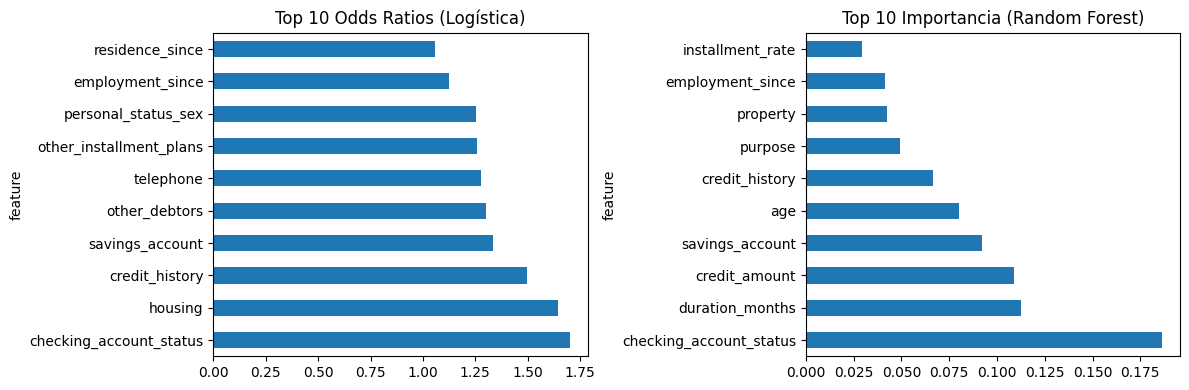

In [23]:
# =====================================================
# Explicabilidad Global
# =====================================================

# --- 1. Regresión Logística: coeficientes y odds ---
log = models["log"]
coefs = log.coef_[0]
features = X.columns
odds = np.exp(coefs)
coef_df = pd.DataFrame({"feature": features, "coef": coefs, "odds_ratio": odds}).sort_values("odds_ratio", ascending=False)
print("\n📊 Coeficientes y Odds Ratios (Logística):")
display(coef_df.round(4))

# --- 2. Random Forest: importancia de variables ---
rf = models["rf"]
imp_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
print("\n🌲 Importancia de Variables (Random Forest):")
display(imp_df.head(10))

# --- 3. Árbol de decisión: reglas de alto riesgo ---
tree_model = models["tree"]
rules = extract_top_rules_from_tree(tree_model, list(features), top_k=3)
print("\n📜 Reglas del Árbol (Segmentos de Alto Riesgo):")
for i, r in enumerate(rules, 1):
    print(f"Regla {i}: SI {r['rule']} -> prob_pos={r['prob_pos']:.2f}, muestras={r['n_samples']}")

# --- Visualización ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
coef_df.set_index("feature")["odds_ratio"].nlargest(10).plot.barh()
plt.title("Top 10 Odds Ratios (Logística)")
plt.subplot(1,2,2)
imp_df.set_index("feature")["importance"].nlargest(10).plot.barh()
plt.title("Top 10 Importancia (Random Forest)")
plt.tight_layout()
plt.show()


### Seleccion de casos para explicabilidad loval

In [24]:
# =====================================================
# Selección de Casos (para análisis local)
# =====================================================

# Probabilidades de clase positiva (usamos RF como referencia)
proba_rf = models["rf"].predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

# 1. Mal clasificado
mis_idx = np.where(pred_rf != y_test.values)[0]
idx_mis = mis_idx[0] if len(mis_idx) > 0 else 0

# 2. Caso frontera (prob ≈ 0.5)
idx_frontera = np.argmin(np.abs(proba_rf - 0.5))

# 3. Caso de alto riesgo (prob > 0.9)
idx_alto = np.argmax(proba_rf)

cases = {"mal_clasificado": idx_mis, "frontera": idx_frontera, "alto_riesgo": idx_alto}
print("🧩 Casos seleccionados:", cases)


🧩 Casos seleccionados: {'mal_clasificado': np.int64(6), 'frontera': np.int64(123), 'alto_riesgo': np.int64(132)}


## Explicabilidad local con SHAP y LIME

In [25]:
# =====================================================
# Explicabilidad Local (3 casos × modelos)
# =====================================================

def explain_local(model_key, idx, X_test, X_test_s, models, feature_names):
    model = models[model_key]
    if model_key == "nn":
        prob = model.predict_proba(X_test_s[idx:idx+1])[0,1]
    else:
        prob = model.predict_proba(X_test.iloc[idx:idx+1])[0,1]
    pred = int(prob >= 0.5)
    print(f"\n--- Modelo: {model_key} | idx: {idx} | prob={prob:.3f} | pred={pred} | true={y_test.values[idx]} ---")
    
    if HAS_SHAP:
        try:
            if model_key in ["rf", "tree"]:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_test.iloc[idx:idx+1])
                sv = shap_values[1][0] if isinstance(shap_values, list) else shap_values[0]
                shap.plots.waterfall(explainer(X_test.iloc[idx:idx+1]), max_display=8)
                print("Factores clave:", business_text_from_shap_values(feature_names, X_test.iloc[idx].values, sv))
            else:
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))
                shap_values = explainer.shap_values(X_test.iloc[idx:idx+1], nsamples=100)
                sv = shap_values[1][0] if isinstance(shap_values, list) else shap_values[0]
                shap.plots.force(explainer(X_test.iloc[idx:idx+1]), matplotlib=True)
                print("Factores clave:", business_text_from_shap_values(feature_names, X_test.iloc[idx].values, sv))
        except Exception as e:
            print("SHAP error:", e)
    elif HAS_LIME:
        explainer = LimeTabularExplainer(
            training_data=np.array(X_train),
            feature_names=feature_names,
            class_names=["0", "1"],
            mode="classification"
        )
        exp = explainer.explain_instance(X_test.iloc[idx].values, model.predict_proba, num_features=6)
        print(exp.as_list())
        exp.as_pyplot_figure()
    else:
        print("⚠️ Ni SHAP ni LIME instalados.")

for name, idx in cases.items():
    print(f"\n================= CASO: {name} =================")
    display(X_test.iloc[idx:idx+1])
    for m in ["rf", "log", "tree", "nn"]:
        explain_local(m, idx, X_test, X_test_s, models, list(X.columns))



================= CASO: mal_clasificado =================


,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,residence_since,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker
94,2,18,4,2.0,6361.0,1,5,2,3,1,1,4,41,3,2,1,3,2,2,2



--- Modelo: rf | idx: 6 | prob=0.479 | pred=0 | true=1 ---
SHAP error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1, 20, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

--- Modelo: log | idx: 6 | prob=0.779 | pred=1 | true=1 ---


100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


SHAP error: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

--- Modelo: tree | idx: 6 | prob=0.679 | pred=1 | true=1 ---
SHAP error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1, 20, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

--- Modelo: nn | idx: 6 | prob=0.676 | pred=1 | true=1 ---


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

SHAP error: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

================= CASO: frontera =================


,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,residence_since,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker
623,1,12,2,2.0,3590.0,1,3,2,3,2,2,2,29,3,2,1,2,1,1,2



--- Modelo: rf | idx: 123 | prob=0.498 | pred=0 | true=1 ---
SHAP error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1, 20, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

--- Modelo: log | idx: 123 | prob=0.699 | pred=1 | true=1 ---


100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


SHAP error: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

--- Modelo: tree | idx: 123 | prob=0.679 | pred=1 | true=1 ---
SHAP error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1, 20, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

--- Modelo: nn | idx: 123 | prob=0.796 | pred=1 | true=1 ---


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

SHAP error: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

================= CASO: alto_riesgo =================


,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,residence_since,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker
77,4,24,4,0.0,1940.0,4,5,4,3,1,4,1,60,3,2,1,3,2,2,2



--- Modelo: rf | idx: 132 | prob=0.921 | pred=1 | true=1 ---
SHAP error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1, 20, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

--- Modelo: log | idx: 132 | prob=0.977 | pred=1 | true=1 ---


100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


SHAP error: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

--- Modelo: tree | idx: 132 | prob=0.908 | pred=1 | true=1 ---
SHAP error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1, 20, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

--- Modelo: nn | idx: 132 | prob=1.000 | pred=1 | true=1 ---


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

SHAP error: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).


### Exportar reporte

In [26]:
# =====================================================
# Exportar explicaciones locales en HTML (para negocio)
# =====================================================

from jinja2 import Template
os.makedirs("explain_reports", exist_ok=True)

html_template = Template("""
<html><head><meta charset='utf-8'><title>Explicación {{case}}</title></head>
<body>
<h2>Explicación Local — {{case}}</h2>
<p><b>Índice:</b> {{idx}}</p>
<table border=1>
{% for k,v in record.items() %}<tr><td>{{k}}</td><td>{{v}}</td></tr>{% endfor %}
</table>
<ul>
{% for m in models %}
<li><b>{{m.name}}</b>: Prob={{m.prob|round(3)}} | Pred={{m.pred}} | {{m.text}}</li>
{% endfor %}
</ul>
</body></html>
""")

for case, idx in cases.items():
    record = X_test.iloc[idx].to_dict()
    models_summary = []
    for m in ["rf", "log", "tree", "nn"]:
        if m == "nn":
            prob = models[m].predict_proba(X_test_s[idx:idx+1])[0,1]
        else:
            prob = models[m].predict_proba(X_test.iloc[idx:idx+1])[0,1]
        pred = int(prob >= 0.5)
        models_summary.append({"name": m, "prob": prob, "pred": pred, "text": "Ver explicación SHAP/LIME"})
    html = html_template.render(case=case, idx=idx, record=record, models=models_summary)
    with open(f"explain_reports/explain_{case}.html", "w", encoding="utf-8") as f:
        f.write(html)

print("✅ Reportes guardados en carpeta `explain_reports/`")


✅ Reportes guardados en carpeta `explain_reports/`
